# Darts

### Import Packages

In [2]:
%matplotlib inline
import os
import datetime
import obspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RegressionModel, ExponentialSmoothing
from darts.ad import ForecastingAnomalyModel, NormScorer, WassersteinScorer
from darts.ad.detectors import QuantileDetector
from darts.ad.utils import eval_metric_from_scores, show_anomalies_from_scores
from darts.metrics import mae, rmse
from darts.dataprocessing.transformers import Scaler

### Get Catalog Data

In [3]:
catalog = pd.read_csv(
    "../../data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
)
catalog

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [4]:
data = pd.read_csv(
    "../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.csv"
)
data = data.rename(columns={"time_abs(%Y-%m-%dT%H:%M:%S.%f)": "datetime"})
data = data.rename(columns={"time_rel(sec)": "reltime"})
data = data.rename(columns={"velocity(m/s)": "speed"})

data["datetime"] = pd.to_datetime(data["datetime"])
data

,datetime,reltime,speed
0,1970-01-19 00:00:00.665000,0.000000,-6.153279e-14
1,1970-01-19 00:00:00.815943,0.150943,-7.701288e-14
2,1970-01-19 00:00:00.966887,0.301887,-8.396187e-14
3,1970-01-19 00:00:01.117830,0.452830,-8.096155e-14
4,1970-01-19 00:00:01.268774,0.603774,-7.097599e-14
...,...,...,...
572410,1970-01-20 00:00:02.174434,86401.509434,-1.472713e-14
572411,1970-01-20 00:00:02.325377,86401.660377,-1.956104e-14
572412,1970-01-20 00:00:02.476321,86401.811321,-2.240307e-14
572413,1970-01-20 00:00:02.627264,86401.962264,-2.998405e-14


From the catalog, grab the true anomaly time, storing it in `true_anomaly`, get its index in the event, storing it in `anomaly_pos`, and then create an empty array of zeroes with a single one at the index at which the anomaly occurs.

In [5]:
true_anomaly = catalog["time_rel(sec)"][0]
anomaly_pos = data.index[data["reltime"] >= true_anomaly][0].tolist()

anomaly = pd.Series([0] * len(data))
anomaly.loc[anomaly_pos] = 1
series_anomaly = TimeSeries.from_series(anomaly)
print(anomaly_pos)

486938


Plot the seismic wave with the point of anomaly for better visualization and proof.

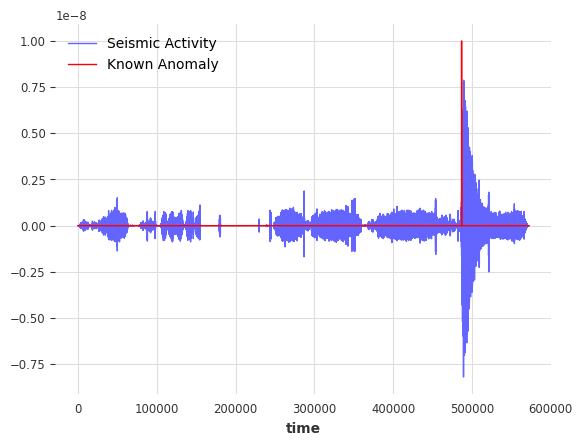

In [6]:
data["speed"].plot(label="Seismic Activity", linewidth=1, color="#6464ff")
(series_anomaly * 10e-9).plot(label="Known Anomaly", color="r", linewidth=1)
plt.show()

Generate time-series from the values of velocity.

In [7]:
series = TimeSeries.from_values(data["speed"])

Split the data into a training and testing set, where the training set is anomaly-free to capture the noise and background activity, and the testing set contains our anomaly.

In `evid00002`, the anomaly is located at `index=486938`.


In [8]:
train = series[450000:485000]
test = series[485000:495000]

# Add covariates (hour and day of the week)
# add_encoders = {
#     # "cyclic": {"future": ["hour", "dayofweek"]},
#     "datetime_attribute": {"future": ["hour", "dayofweek"]},
# }

window = 50

forecasting_model = RegressionModel(
    lags=window,
    output_chunk_length=1,
    # lags_future_covariates=[0],
    # add_encoders=add_encoders,
)

forecasting_model.fit(train)

RegressionModel(lags=50, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, model=None, multi_models=True, use_static_covariates=True)

In [9]:
short = 10
long = 20

anomaly_model = ForecastingAnomalyModel(
    model=forecasting_model,
    scorer=[
        NormScorer(ord=1),
        WassersteinScorer(window=short, window_agg=False),
        WassersteinScorer(window=long, window_agg=True),
    ],
)

In [10]:
START = 0.1
anomaly_model.fit(train, start=START, allow_model_training=False, verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
anomaly_scores, model_forecasting = anomaly_model.score(
    test, start=START, return_model_prediction=True, verbose=True
)
pred_start = model_forecasting.start_time()

  0%|          | 0/1 [00:00<?, ?it/s]

On testing set -> MAE: 3.200239382516645e-10, RMSE: 4.3973386321584136e-10


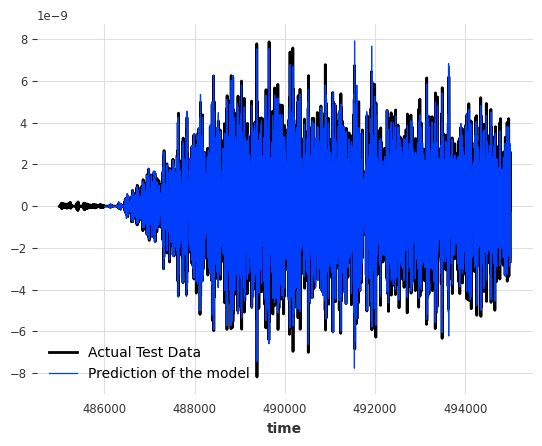

In [12]:
print(
    "On testing set -> MAE: {}, RMSE: {}".format(
        mae(model_forecasting, test), rmse(model_forecasting, test)
    )
)

# plot the data and the anomalies
# fig, ax = plt.subplots(figsize=(15, 5))
test.plot(label="Actual Test Data")
model_forecasting.plot(label="Prediction of the model", linewidth=0.9)
plt.show()

In [13]:
metric_names = ["AUC_ROC", "AUC_PR"]
metric_data = []
for metric_name in metric_names:
    metric_data.append(
        anomaly_model.eval_metric(
            anomalies=series_anomaly,
            series=test,
            # start=START,
            metric=metric_name,
        )
    )
pd.DataFrame(data=metric_data, index=metric_names).T

,AUC_ROC,AUC_PR
Norm (ord=1)_w=1,0.158609,0.000119
WassersteinScorer_w=10,0.265381,0.000744
WassersteinScorer_w=20,0.215851,0.001347


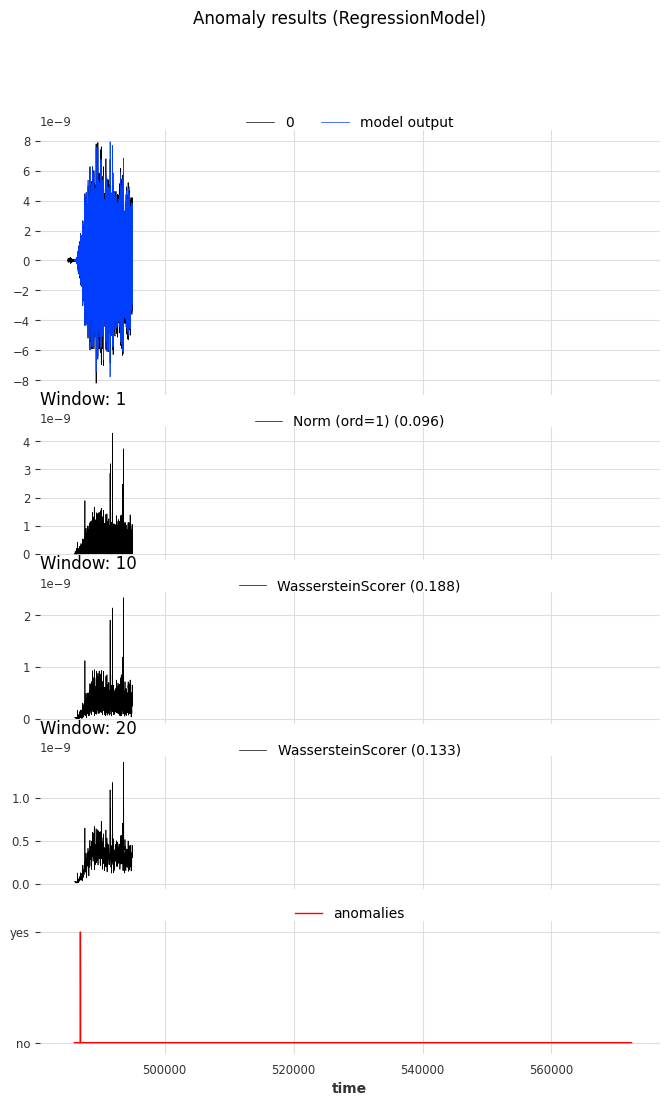

In [14]:
anomaly_model.show_anomalies(
    series=test,
    anomalies=series_anomaly[pred_start:],
    start=START,
    metric="AUC_ROC",
)

### Converting the anomaly score to a binary prediction

We will use Darts' anomaly detectors to convert anomaly scores into binary anomalies/predictions by using `QuantileDetector`.

This function detects anomalies based on the quantile values `high_quantile` or `low_quantile` of historical data. It flags times as anomalous when the values exceed these quantile thresholds.

We set high_quantile to 0.99. This value must be chosen carefully, as it will convert the $(1-$ `high_quantile` $) * 100$ % biggest anomaly scores into a prediction of anomalies. In our case, we want to see the 1% most anomalous timestamps.


In [61]:
contamination = 0.9999
detector = QuantileDetector(high_quantile=contamination)

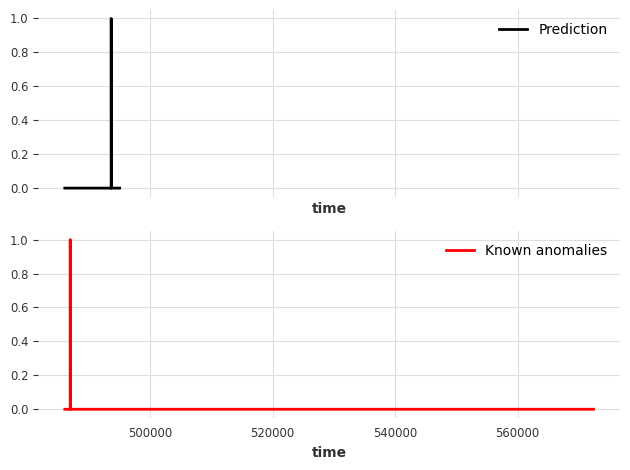

In [62]:
# Use the anomaly score that gave the best AUC ROC score: Wasserstein anomaly score with a window of 'long'
best_anomaly_score = anomaly_scores[-1]

# fit and detect on the anomaly scores, it will return a binary prediction
anomaly_pred = detector.fit_detect(series=best_anomaly_score)

# plot the binary prediction
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
anomaly_pred.plot(label="Prediction", ax=ax1)
series_anomaly[anomaly_pred.start_time() :].plot(
    label="Known anomalies", ax=ax2, color="red"
)
fig.tight_layout()

In [63]:
for i in range(len(anomaly_pred)):
    if anomaly_pred[i] >= 0.9999:
        print(i)
        break

7586


In [64]:
for metric_name in ["accuracy", "precision", "recall", "f1"]:
    metric_val = detector.eval_metric(
        pred_scores=best_anomaly_score,
        anomalies=series_anomaly,
        window=long,
        metric=metric_name,
    )
    print(metric_name + f": {metric_val:.2f}/1")

accuracy: 0.99/1
precision: 0.00/1
recall: 0.00/1
f1: 0.00/1


We can call `eval_metric_from_scores()` and `show_anomalies_from_scores()` directly with pre-computed anomaly scores to avoid having to re-generate the scores each time through methods `eval_metric()` and `show_anomalies()`.

Let's reproduce the results from above. Both functions require the window sizes used to compute each of the anomaly scores. In our case, the window sizes were 1, 20 (`short`), 500 (`long`).


In [65]:
windows = [1, short, long]
scorer_names = [f"{scorer}_{w}" for scorer, w in zip(anomaly_model.scorers, windows)]

metric_data = {"AUC_ROC": [], "AUC_PR": []}
for metric_name in metric_data:
    metric_data[metric_name] = eval_metric_from_scores(
        anomalies=series_anomaly,
        pred_scores=anomaly_scores,
        window=windows,
        metric=metric_name,
    )

pd.DataFrame(index=scorer_names, data=metric_data)

,AUC_ROC,AUC_PR
Norm (ord=1)_1,0.072889,0.000120
WassersteinScorer_20,0.136755,0.001344
WassersteinScorer_50,0.124720,0.003252


As expected, the AUC ROC and AUC PR values are identical to before.

For visualizing the anomalies:

-   If we want to compute a metric, we need to specify the window sizes as well
-   Optionally, we can indicate the scorers' names that generated the scores


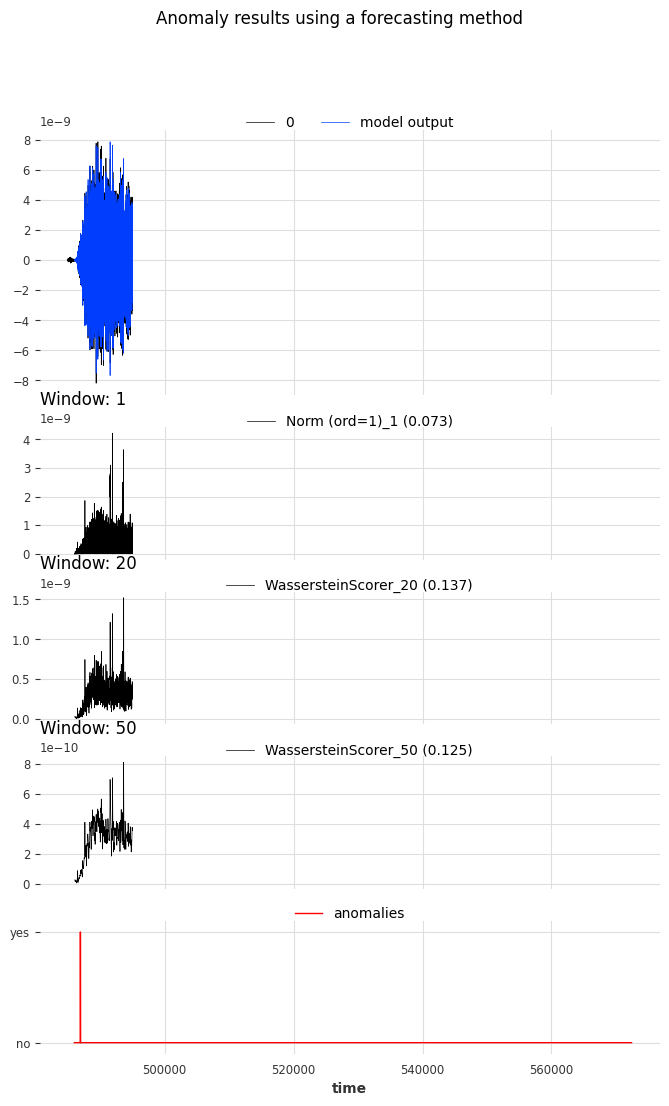

In [66]:
show_anomalies_from_scores(
    series=test,
    anomalies=series_anomaly[pred_start:],
    pred_scores=anomaly_scores,
    pred_series=model_forecasting,
    window=windows,
    title="Anomaly results using a forecasting method",
    names_of_scorers=scorer_names,
    metric="AUC_ROC",
)

### Visualize Results

We will create functions that help us plot a zoomed in section onto the anomalies detected.


486438 487488


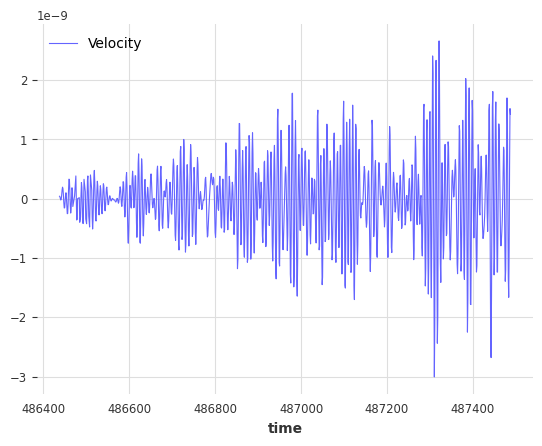

In [67]:
long = 50
start = anomaly_pos - long * 10
end = anomaly_pos + long * (10 + 1)

# input series and forecasts
series[start:end].plot(label="Velocity", color="#6464ff", linewidth=0.8)
print(start, end)

<Axes: xlabel='time'>

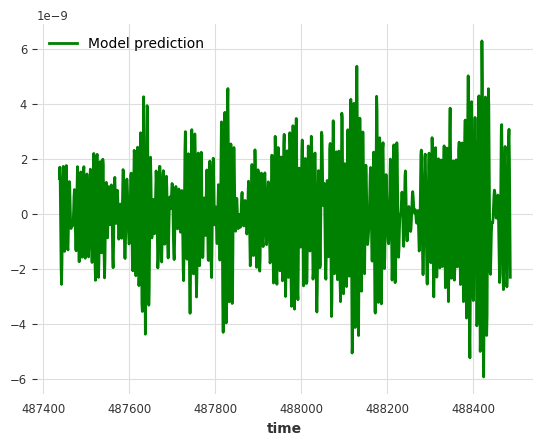

In [68]:
model_forecasting[start - 485000 : end - 485000].plot(
    label="Model prediction", color="green"
)
# model_forecasting

<Axes: xlabel='time'>

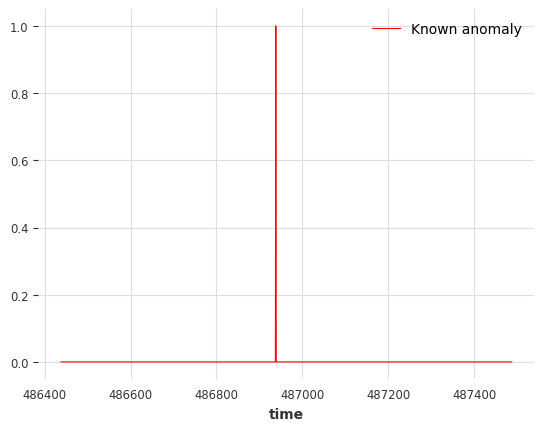

In [69]:
# actual anomalies and predicted scores
(series_anomaly[start:end]).plot(label="Known anomaly", color="r", linewidth=0.8)

<Axes: xlabel='time'>

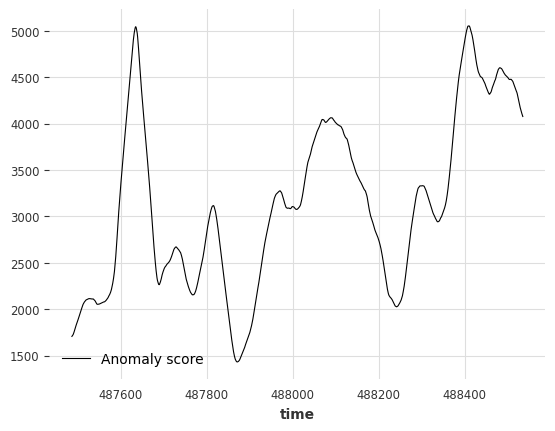

In [72]:
# Scaler transforms scores into a value range between (0, 1)
(
    Scaler().fit_transform(best_anomaly_score)[start - 485000 : end - 485000] * 10000
).plot(label="Anomaly score", color="black", linewidth=0.8)
# plt.legend(loc="upper center", ncols=2)
# plt.title(anomaly)
# fig.tight_layout()
# plt.show()